Disclaimer:  
- After evaluating various models and deriving multiple features—both created and eliminated—and conducting several rounds of hyperparameter tuning for each model, we present the following concise script that highlights the performance of a single selected model, with selected features.  
- This representation does not fully capture the total effort put forth by the team.

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, root_mean_squared_error
from xgboost import XGBRegressor
import joblib

In [61]:
df = pd.read_csv("AviationCleaned.csv")

In [3]:
df.head()

,Flight Number,Scheduled Departure Time,Actual Departure Time,Delay (Minutes),Aircraft Utilization (Hours/Day),Turnaround Time (Minutes),Load Factor (%),Fleet Availability (%),Maintenance Downtime (Hours),Fuel Efficiency (ASK),Revenue (USD),Operating Cost (USD),Net Profit Margin (%),Ancillary Revenue (USD),Debt-to-Equity Ratio,Revenue per ASK,Cost per ASK,Profit (USD)
0,FL885,2024-05-20 11:51:21,2024-07-10 02:38:54,50,12.36,115,79.18,96.24,9.21,4.15,10953.75,27847.59,17.90,1058.68,2.46,2639.46,6710.26,-16893.84
1,FL930,2024-01-23 06:56:23,2024-07-07 02:53:44,27,14.53,83,98.59,80.49,1.55,3.93,31597.25,1564.41,7.70,2941.32,2.89,8040.01,791.89,30032.84
2,FL478,2024-05-30 09:18:39,2024-12-05 01:00:54,108,10.73,87,67.44,97.90,2.06,4.26,13700.27,30494.88,5.84,1920.45,1.34,3216.03,7158.42,-16794.61
3,FL637,2024-08-15 05:21:47,2024-09-21 13:23:42,64,15.10,99,69.01,80.17,6.85,4.13,39913.01,13444.09,24.09,3167.79,0.60,9664.17,3255.23,26468.92
4,FL318,2024-07-25 15:29:58,2024-03-21 15:05:54,30,13.46,114,50.36,82.23,7.30,4.97,11531.48,34668.98,7.18,619.80,0.84,2320.22,6975.65,-23137.50


In [43]:
df['Scheduled Departure Time'] = pd.to_datetime(df['Scheduled Departure Time'])
df['Actual Departure Time'] = pd.to_datetime(df['Actual Departure Time'])

In [6]:
df.describe()

,Scheduled Departure Time,Actual Departure Time,Delay (Minutes),Aircraft Utilization (Hours/Day),Turnaround Time (Minutes),Load Factor (%),Fleet Availability (%),Maintenance Downtime (Hours),Fuel Efficiency (ASK),Revenue (USD),Operating Cost (USD),Net Profit Margin (%),Ancillary Revenue (USD),Debt-to-Equity Ratio,Revenue per ASK,Cost per ASK,Profit (USD)
count,200000,200000,200000.00000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000
mean,2024-06-29 07:21:27.048759808,2024-06-29 08:55:04.200095232,59.35885,12.003438,74.451680,74.997178,85.001378,5.503103,3.496959,25571.448338,20429.003323,15.011169,2550.025537,1.752445,7719.235363,6165.556007,5142.445015
min,2024-01-01 00:01:53,2024-01-01 00:03:34,0.00000,8.000000,30.000000,50.000000,70.000000,1.000000,2.000000,1000.060000,800.030000,5.000000,100.020000,0.500000,998.300000,791.890000,-38973.960000
25%,2024-03-30 22:12:47,2024-03-30 15:40:28.249999872,29.00000,9.990000,52.000000,62.500000,77.480000,3.250000,2.750000,13297.042500,10609.022500,10.010000,1325.570000,1.130000,3812.782500,3041.547500,-7983.690000
50%,2024-06-29 10:33:27,2024-06-28 20:10:25,59.00000,12.010000,74.000000,74.960000,85.000000,5.500000,3.490000,25566.300000,20410.885000,15.000000,2544.210000,1.750000,7315.460000,5834.705000,5216.975000
75%,2024-09-27 09:33:27.500000,2024-09-28 03:54:08.500000,89.00000,14.010000,97.000000,87.530000,92.530000,7.760000,4.250000,37860.402500,30245.907500,20.010000,3776.387500,2.370000,10909.272500,8715.670000,18269.647500
max,2024-12-27 05:14:39,2024-12-27 05:07:36,119.00000,16.000000,119.000000,100.000000,100.000000,10.000000,5.000000,49999.950000,39999.840000,25.000000,5000.000000,3.000000,17135.810000,13698.490000,49054.690000
std,NaN,NaN,34.67602,2.311966,25.977826,14.439393,8.672413,2.601257,0.865309,14158.512116,11316.410641,5.778340,1414.291993,0.720194,4646.052540,3715.508499,18123.595784


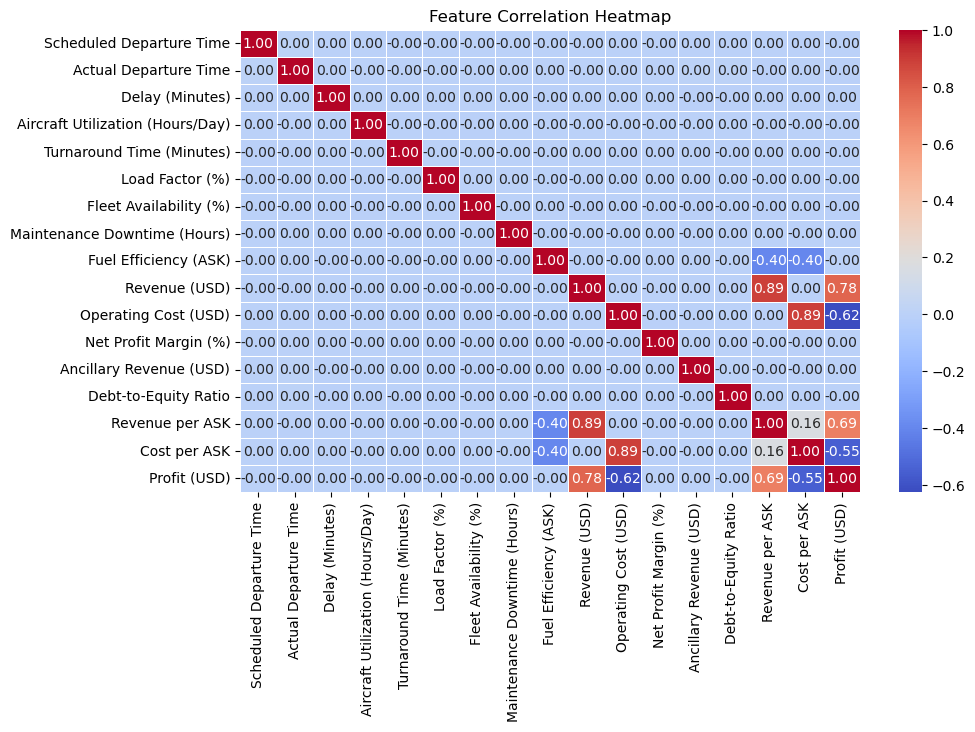

In [7]:
plt.figure(figsize=(10, 6))
sns.heatmap(df.corr(), annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

In [67]:
# Derived Features

df['Cost per Flight Hour'] = df['Operating Cost (USD)'] / df['Aircraft Utilization (Hours/Day)']

In [72]:
x = df[['Cost per ASK', 'Cost per Flight Hour', 'Revenue per ASK', 'Fuel Efficiency (ASK)']]


y = df['Profit (USD)']

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=25)

## XGBoost

## Hypertuning
Following Cell contains code that is CPU intensive. Caution is advised.

In [11]:
param_dist = {
    'n_estimators': [100, 300, 500, 800, 1000],
    'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
    'max_depth': [3, 5, 7, 9, 12],
    'min_child_weight': [1, 3, 5, 7, 10],
    'gamma': [0, 0.1, 0.2, 0.3, 0.5],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.01, 0.1, 1, 10],
    'reg_lambda': [0, 0.01, 0.1, 1, 10]
}

xgb_model = XGBRegressor(random_state=24)

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=50, cv=5, scoring='r2', n_jobs=1, verbose=1, random_state=41)

random_search.fit(x_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best r2 score:", random_search.best_score_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 10, 'max_depth': 9, 'learning_rate': 0.01, 'gamma': 0.5, 'colsample_bytree': 1.0}
Best r2 score: 0.9969498410725988


## XGBoost Model Training

In [55]:
xgb = XGBRegressor(subsample=0.6, reg_lambda=1, reg_alpha=0.01, n_estimators=500, min_child_weight=10, max_depth=9, learning_rate=0.01,
                   gamma=0.5, colsample_bytree=1.0)

In [56]:
xgb.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.5, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=10, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
y_pred = xgb.predict(x_test)

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test, y_pred)

print(f"XGBoost R² Score: {r2}")
print(f"Mean Absolute Error: {mae}")
print(f"Mean Squared Error: {mse}")
print(f"Root Mean Squared Error: {rmse}")

cv_scores = cross_val_score(xgb, x_train, y_train, cv=5, scoring="r2")

print("\nCross-validation R² scores:", cv_scores)
print("Mean CV R²:", cv_scores.mean())

XGBoost R² Score: 0.9967937195563126
Mean Absolute Error: 452.12887633289813
Mean Squared Error: 1052741.945585343
Root Mean Squared Error: 1026.0321367215274

Cross-validation R² scores: [0.99688949 0.99705896 0.99695885 0.99687706 0.99694519]
Mean CV R²: 0.996945908614973


In [15]:
train_r2 = xgb.score(x_train, y_train)
test_r2 = xgb.score(x_test, y_test)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

Train R²: 0.9973
Test R²: 0.9968


In [16]:
xgb_feature_imp = pd.DataFrame(
    {
        "Features":x.columns,
        "Importances":xgb.feature_importances_
    }
)
xgb_feature_imp.sort_values(by='Importances', ascending=False)

,Features,Importances
2,Revenue per ASK,0.552276
0,Cost per ASK,0.422140
3,Fuel Efficiency (ASK),0.014415
1,Cost per Flight Hour,0.011169


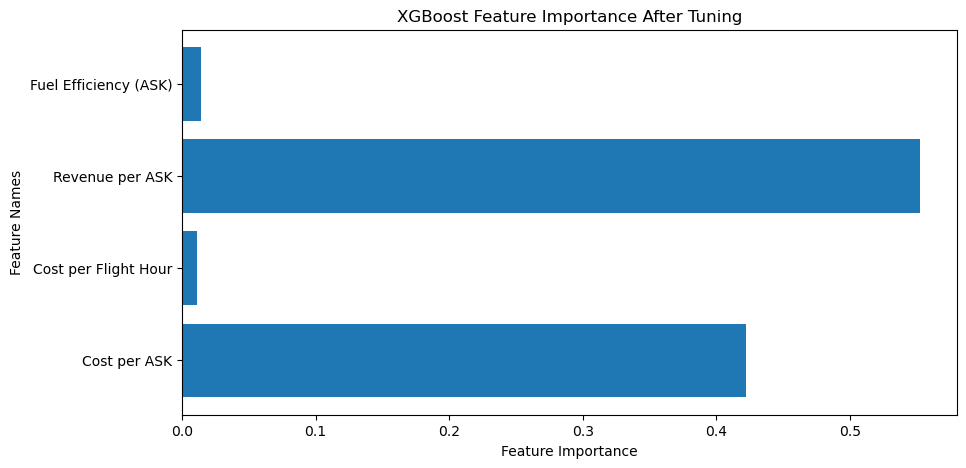

In [20]:
plt.figure(figsize=(10, 5))
plt.barh(y=xgb_feature_imp['Features'], width=xgb_feature_imp['Importances'])
plt.xlabel("Feature Importance")
plt.ylabel("Feature Names")
plt.title("XGBoost Feature Importance After Tuning")
plt.show()

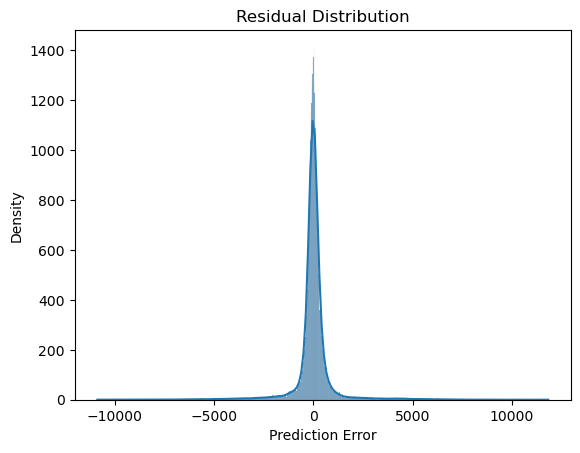

In [58]:
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel("Prediction Error")
plt.ylabel("Density")
plt.title("Residual Distribution")
plt.show()


In [25]:
joblib.dump(xgb, "ml_model.pkl")
print('Model Saved Successfully!')

Model Saved Successfully!


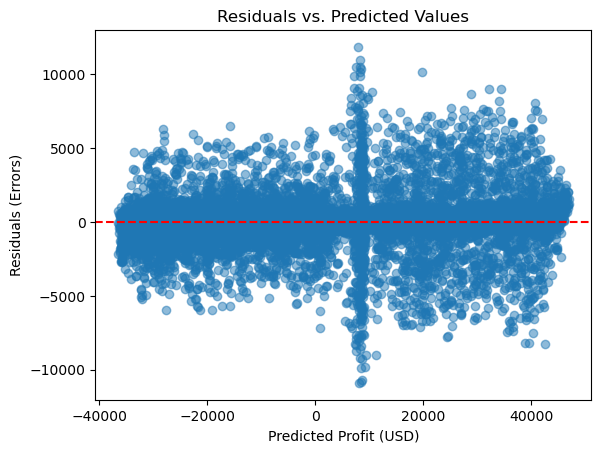

In [26]:
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Profit (USD)")
plt.ylabel("Residuals (Errors)")
plt.title("Residuals vs. Predicted Values")
plt.show()


In [ ]:
# Creating a predicted dataset for dashboard
df_full = pd.read_csv("AviationCleaned.csv")
df_full['Cost per Flight Hour'] = df_full['Operating Cost (USD)'] / df_full['Aircraft Utilization (Hours/Day)']
df_full['Predicted Profit'] = xgb.predict(df_full[['Cost per ASK', 'Cost per Flight Hour', 'Revenue per ASK', 'Fuel Efficiency (ASK)']])
df_full['Error'] = df_full['Profit (USD)'] - df_full['Predicted Profit']
df_full.to_csv("Aviation_Predictions")